In [1]:
# ================================================================
#  SETUP — Kaggle Notebook Version (NO COLAB, NO kaggle.json)
# ================================================================

import os, json, random
from pathlib import Path
import copy  # <-- NEW: for safe rollback on bad pruning

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import torch.nn.utils.prune as prune

# -------------------------
#  Dataset paths (Kaggle)
# -------------------------
DATA_ROOT = "/kaggle/input/paribahan-bd"
LOCAL_VEHICLES_DIR = os.path.join(DATA_ROOT, "Local-Vehicles", "Local-Vehicles")

print("DATA ROOT CONTENTS:", os.listdir(DATA_ROOT))
print("VEHICLE CLASS FOLDERS:", os.listdir(LOCAL_VEHICLES_DIR))

# -------------------------
#  Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -------------------------
#  Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================================================================
#  TRANSFORMS
# ================================================================
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225],
    ),
])

# ================================================================
#  LOAD DATA
# ================================================================
base_dataset = datasets.ImageFolder(root=LOCAL_VEHICLES_DIR, transform=None)
print("Found classes:", base_dataset.classes)
NUM_CLASSES = len(base_dataset.classes)

indices = np.arange(len(base_dataset))
labels = np.array(base_dataset.targets)

train_idx, tmp_idx, y_train, y_tmp = train_test_split(
    indices, labels, test_size=0.3, random_state=SEED, stratify=labels
)
val_idx, test_idx, y_val, y_test = train_test_split(
    tmp_idx, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp
)

print(f"TOTAL SAMPLES: {len(base_dataset)}")
print(f"TRAIN: {len(train_idx)} | VAL: {len(val_idx)} | TEST: {len(test_idx)}")

# ================================================================
#  CUSTOM DATASET
# ================================================================
class IndexedImageFolder(Dataset):
    def __init__(self, base_ds, indices, transform=None):
        self.base = base_ds
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.base[self.indices[i]]
        img = img.convert("RGB")  # ensure RGB
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_dataset_global = IndexedImageFolder(base_dataset, train_idx, transform=train_transform)
val_dataset_global   = IndexedImageFolder(base_dataset, val_idx,   transform=eval_transform)
test_dataset_global  = IndexedImageFolder(base_dataset, test_idx,  transform=eval_transform)

train_loader_global = DataLoader(train_dataset_global, batch_size=BATCH_SIZE,
                                 shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader_global   = DataLoader(val_dataset_global, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader_global  = DataLoader(test_dataset_global, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ================================================================
#  EXPERT MODELS (EfficientNet B0/B1/B2)
# ================================================================
EXPERT_BACKBONES = ["efficientnet_b0", "efficientnet_b1", "efficientnet_b2"]
NUM_EXPERTS = len(EXPERT_BACKBONES)
BOOTSTRAP_RATIO = 0.7

TRIAL_EPOCHS = 1
FULL_EPOCHS  = 2

LAMBDA_GL = 1e-5
PRUNE_AMOUNT = 0.3
PRUNE_FT_EPOCHS = 1

KD_TEMPERATURE = 4.0
KD_ALPHA = 0.3
KD_EPOCHS = 3

LR_EXPERT = 1e-4
LR_STUDENT = 1e-3

criterion_ce = nn.CrossEntropyLoss()

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def group_lasso_penalty(model):
    gl = 0.0
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            w = m.weight
            w_norm = w.pow(2).sum(dim=(1, 2, 3)).sqrt()
            gl += w_norm.sum()
    return gl

def build_efficientnet_expert(name, num_classes):
    if name == "efficientnet_b0":
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    elif name == "efficientnet_b1":
        m = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
    elif name == "efficientnet_b2":
        m = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
    else:
        raise ValueError("Unknown EfficientNet variant")

    in_features = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_features, num_classes)
    return m.to(device)


experts = []
for name in EXPERT_BACKBONES:
    model = build_efficientnet_expert(name, NUM_CLASSES)
    print(f"Built expert {name} with {count_params(model)/1e6:.2f}M params")
    experts.append(model)

# ================================================================
#  TRAINING FUNCTIONS
# ================================================================
def train_one_epoch_single_model(model, dataloader, optimizer, criterion, device, lambda_gl=0.0):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        ce_loss = criterion(out, labels)

        loss = ce_loss + lambda_gl * group_lasso_penalty(model)
        loss.backward()
        optimizer.step()

        total_loss += ce_loss.item() * images.size(0)
        total_correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, total_correct / total


def evaluate_single_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            loss = criterion(out, labels)

            total_loss += loss.item() * images.size(0)
            total_correct += (out.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, total_correct / total

def structured_channel_prune(model, amount):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            prune.ln_structured(m, name="weight", amount=amount, n=2, dim=0)
            prune.remove(m, "weight")

# ================================================================
#  TRAIN EXPERT MODELS
# ================================================================
expert_val_scores = []

for i, expert in enumerate(experts):
    print(f"\n=== Training Expert {i+1}/{NUM_EXPERTS} ===")

    n_train = len(train_dataset_global)
    sub_size = int(BOOTSTRAP_RATIO * n_train)
    sub_idx = np.random.choice(np.arange(n_train), size=sub_size, replace=True)
    train_subset = torch.utils.data.Subset(train_dataset_global, sub_idx)

    train_loader_expert = DataLoader(
        train_subset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True
    )

    optimizer = torch.optim.AdamW(expert.parameters(), lr=LR_EXPERT, weight_decay=1e-4)

    # Trial training
    for epoch in range(1, TRIAL_EPOCHS + 1):
        t_loss, t_acc = train_one_epoch_single_model(expert, train_loader_expert, optimizer, criterion_ce, device, LAMBDA_GL)
        v_loss, v_acc = evaluate_single_model(expert, val_loader_global, criterion_ce, device)
        print(f"[Trial {epoch}/{TRIAL_EPOCHS}] Train={t_acc:.3f}, Val={v_acc:.3f}")

    # Full training
    for epoch in range(1, FULL_EPOCHS + 1):
        t_loss, t_acc = train_one_epoch_single_model(expert, train_loader_expert, optimizer, criterion_ce, device, LAMBDA_GL)
        v_loss, v_acc = evaluate_single_model(expert, val_loader_global, criterion_ce, device)
        print(f"[Full {epoch}/{FULL_EPOCHS}] Train={t_acc:.3f}, Val={v_acc:.3f}")

    expert_val_scores.append(v_acc)

print("\nValidation scores:", expert_val_scores)

# ================================================================
#  PRUNE EXPERTS (with rollback if accuracy collapses)
# ================================================================
for i, expert in enumerate(experts):
    print(f"\n=== Pruning Expert {i+1} ===")
    before_params = count_params(expert)
    pre_val = expert_val_scores[i]
    before_state = copy.deepcopy(expert.state_dict())  # save pre-prune weights

    structured_channel_prune(expert, PRUNE_AMOUNT)
    after_params = count_params(expert)
    print(f"Params: {before_params/1e6:.2f}M → {after_params/1e6:.2f}M")

    optimizer = torch.optim.AdamW(expert.parameters(), lr=LR_EXPERT)
    t_loss, t_acc = train_one_epoch_single_model(
        expert, train_loader_global, optimizer, criterion_ce, device, lambda_gl=0.0
    )
    v_loss, v_acc = evaluate_single_model(expert, val_loader_global, criterion_ce, device)
    print(f"After prune FT: Train={t_acc:.3f}, Val={v_acc:.3f}")

    # If pruning hurts too much, revert
    if v_acc < pre_val * 0.95:
        print(f"Pruning degraded Expert {i+1} too much (pre_val={pre_val:.3f}), reverting weights.")
        expert.load_state_dict(before_state)
        # keep original expert_val_scores[i]
    else:
        print(f"Pruning accepted for Expert {i+1}.")
        expert_val_scores[i] = v_acc  # update to post-prune val if good

# ================================================================
#  FOREST WEIGHTS
# ================================================================
val_scores = np.array(expert_val_scores)
forest_weights = val_scores / val_scores.sum() if val_scores.sum() > 0 else np.ones_like(val_scores) / len(val_scores)
forest_weights = torch.tensor(forest_weights, dtype=torch.float32, device=device)
print("\nForest Weights:", forest_weights.cpu().tolist())

def forest_logits(experts, images, weights=None):
    for m in experts:
        m.eval()
    with torch.no_grad():
        logits = torch.stack([m(images) for m in experts])
    if weights is None:
        return logits.mean(0)
    return (logits * weights.view(-1, 1, 1)).sum(0)

# ================================================================
#  STUDENT MODEL (MobileNetV3)
# ================================================================
def build_student_model(num_classes):
    m = models.mobilenet_v3_small(
        weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
    )
    in_features = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_features, num_classes)
    return m.to(device)

student = build_student_model(NUM_CLASSES)
print("Student params:", count_params(student)/1e6, "M")

def kd_loss_fn(s_logits, t_logits, labels, T, alpha):
    ce = criterion_ce(s_logits, labels)
    log_p_s = F.log_softmax(s_logits / T, dim=1)
    p_t = F.softmax(t_logits / T, dim=1)
    kd = F.kl_div(log_p_s, p_t, reduction="batchmean") * (T**2)
    return alpha * ce + (1 - alpha) * kd, ce, kd

optimizer_student = torch.optim.AdamW(student.parameters(), lr=LR_STUDENT)

print("\n=== TRAINING STUDENT WITH KD ===")
for epoch in range(1, KD_EPOCHS + 1):
    student.train()
    total_correct = 0
    total = 0
    total_loss = 0

    for images, labels in train_loader_global:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            t_logits = forest_logits(experts, images, weights=forest_weights)

        optimizer_student.zero_grad()
        s_logits = student(images)
        loss, ce, kd = kd_loss_fn(s_logits, t_logits, labels, KD_TEMPERATURE, KD_ALPHA)
        loss.backward()
        optimizer_student.step()

        total_loss += loss.item() * images.size(0)
        total_correct += (s_logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = total_correct / total
    val_acc = evaluate_single_model(student, val_loader_global, criterion_ce, device)[1]

    print(f"[KD {epoch}/{KD_EPOCHS}] Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")

# ================================================================
#  TEST ACCURACY
# ================================================================
test_acc = evaluate_single_model(student, test_loader_global, criterion_ce, device)[1]
print("\nFinal Student Test Accuracy:", test_acc)
print("Forest params:", sum(count_params(e) for e in experts)/1e6, "M")
print("Student params:", count_params(student)/1e6, "M")


DATA ROOT CONTENTS: ['Local-Vehicles', 'generated_images']
VEHICLE CLASS FOLDERS: ['Van', 'Rickshaw', 'Bus', 'Truck', 'Tractor', 'Car', 'Leguna', 'Boat', 'Wheelbarrow', 'Bicycle', 'Easy-bike', 'Horse-cart', 'Cng', 'Bike']
Using device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Found classes: ['Bicycle', 'Bike', 'Boat', 'Bus', 'Car', 'Cng', 'Easy-bike', 'Horse-cart', 'Leguna', 'Rickshaw', 'Tractor', 'Truck', 'Van', 'Wheelbarrow']
TOTAL SAMPLES: 7474
TRAIN: 5231 | VAL: 1121 | TEST: 1122


100%|██████████| 20.5M/20.5M [00:00<00:00, 75.9MB/s]


Built expert efficientnet_b0 with 4.03M params


Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 232MB/s]


Built expert efficientnet_b1 with 6.53M params


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 225MB/s]


Built expert efficientnet_b2 with 7.72M params

=== Training Expert 1/3 ===


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Trial 1/1] Train=0.578, Val=0.819


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Full 1/2] Train=0.886, Val=0.935


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Full 2/2] Train=0.951, Val=0.947

=== Training Expert 2/3 ===


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Trial 1/1] Train=0.563, Val=0.818


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Full 1/2] Train=0.872, Val=0.906


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Full 2/2] Train=0.941, Val=0.925

=== Training Expert 3/3 ===


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Trial 1/1] Train=0.609, Val=0.830


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Full 1/2] Train=0.897, Val=0.933


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Full 2/2] Train=0.954, Val=0.951

Validation scores: [0.9473684210526315, 0.9250669045495094, 0.9509366636931311]

=== Pruning Expert 1 ===
Params: 4.03M → 4.03M


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


After prune FT: Train=0.095, Val=0.095
Pruning degraded Expert 1 too much (pre_val=0.947), reverting weights.

=== Pruning Expert 2 ===
Params: 6.53M → 6.53M


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


After prune FT: Train=0.096, Val=0.095
Pruning degraded Expert 2 too much (pre_val=0.925), reverting weights.

=== Pruning Expert 3 ===
Params: 7.72M → 7.72M


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


After prune FT: Train=0.096, Val=0.095
Pruning degraded Expert 3 too much (pre_val=0.951), reverting weights.

Forest Weights: [0.33554503321647644, 0.3276461362838745, 0.33680886030197144]


100%|██████████| 9.83M/9.83M [00:00<00:00, 170MB/s]

Student params: 1.532206 M

=== TRAINING STUDENT WITH KD ===



/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[KD 1/3] Train Acc=0.784, Val Acc=0.875


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[KD 2/3] Train Acc=0.919, Val Acc=0.905


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[KD 3/3] Train Acc=0.938, Val Acc=0.926


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Final Student Test Accuracy: 0.9197860962566845
Forest params: 18.27732 M
Student params: 1.532206 M


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in by


=== BENCHMARK RESULTS ===
                        model     role   params_M   val_acc  test_acc
0  Expert_1 (efficientnet_b0)   expert   4.025482  0.947368  0.950980
1  Expert_2 (efficientnet_b1)   expert   6.531118  0.925067  0.935829
2  Expert_3 (efficientnet_b2)   expert   7.720720  0.950937  0.950089
3              Forest_Teacher   forest  18.277320  0.965210  0.959893
4   Student_MobileNetV3_Small  student   1.532206  0.925959  0.919786

Saved benchmark_results.csv


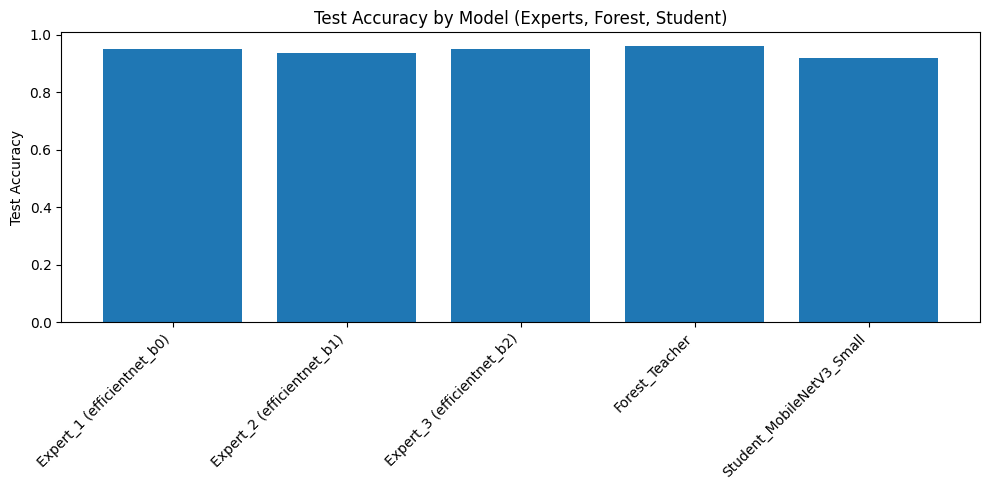

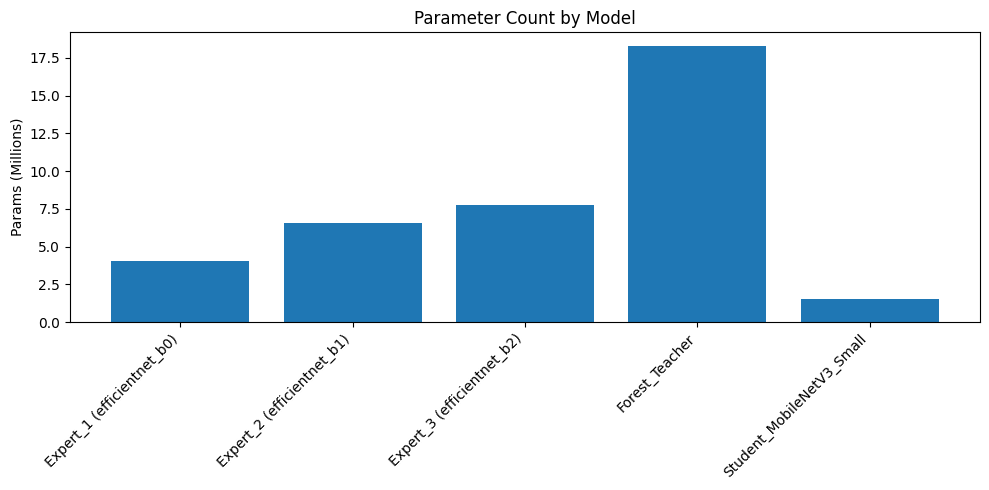

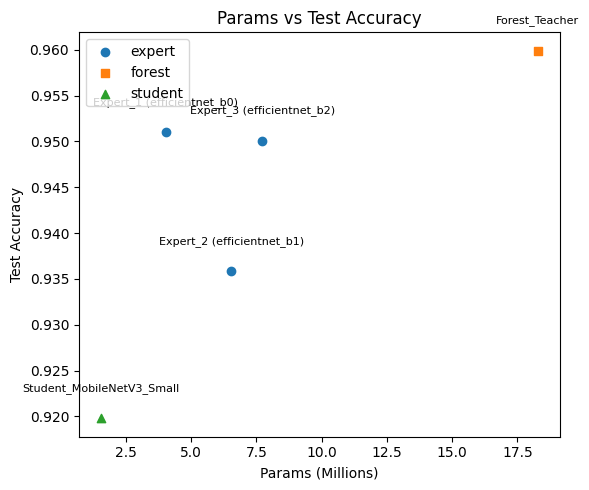

In [2]:
# ================================================================
#  BENCHMARKING & PLOTS (run AFTER training & KD)
# ================================================================
import pandas as pd
import matplotlib.pyplot as plt

# If running in Kaggle, inline plotting is enabled by default.

def eval_model_top1(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


def eval_forest_top1(experts, dataloader, device, weights=None):
    for m in experts:
        m.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = torch.stack([m(images) for m in experts])  # [E,B,C]
            if weights is not None:
                w = weights.view(-1, 1, 1)
                logits = logits * w
                logits = logits.sum(0)
            else:
                logits = logits.mean(0)
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


# ------------------------------------------------
# Collect metrics for experts, forest, and student
# ------------------------------------------------
rows = []

# Individual experts
for i, (name, expert) in enumerate(zip(EXPERT_BACKBONES, experts), start=1):
    val_acc = eval_model_top1(expert, val_loader_global, device)
    test_acc = eval_model_top1(expert, test_loader_global, device)
    params_m = count_params(expert) / 1e6

    rows.append({
        "model": f"Expert_{i} ({name})",
        "role": "expert",
        "params_M": params_m,
        "val_acc": val_acc,
        "test_acc": test_acc,
    })

# Forest teacher (ensemble)
forest_params_m = sum(count_params(e) for e in experts) / 1e6
forest_val_acc = eval_forest_top1(experts, val_loader_global, device, weights=forest_weights)
forest_test_acc = eval_forest_top1(experts, test_loader_global, device, weights=forest_weights)

rows.append({
    "model": "Forest_Teacher",
    "role": "forest",
    "params_M": forest_params_m,
    "val_acc": forest_val_acc,
    "test_acc": forest_test_acc,
})

# Student (KD MobileNetV3-Small)
student_val_acc = eval_model_top1(student, val_loader_global, device)
student_test_acc = eval_model_top1(student, test_loader_global, device)
student_params_m = count_params(student) / 1e6

rows.append({
    "model": "Student_MobileNetV3_Small",
    "role": "student",
    "params_M": student_params_m,
    "val_acc": student_val_acc,
    "test_acc": student_test_acc,
})

# ------------------------------------------------
# DataFrame + CSV
# ------------------------------------------------
results_df = pd.DataFrame(rows)
print("\n=== BENCHMARK RESULTS ===")
print(results_df)

results_df.to_csv("benchmark_results.csv", index=False)
print("\nSaved benchmark_results.csv")

# ------------------------------------------------
# Plot 1: Test accuracy bar plot
# ------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(results_df["model"], results_df["test_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy by Model (Experts, Forest, Student)")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Plot 2: Parameter counts bar plot
# ------------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(results_df["model"], results_df["params_M"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Params (Millions)")
plt.title("Parameter Count by Model")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# Plot 3: Params vs Test Accuracy scatter
# ------------------------------------------------
plt.figure(figsize=(6, 5))
for role, marker in [("expert", "o"), ("forest", "s"), ("student", "^")]:
    subset = results_df[results_df["role"] == role]
    if len(subset) == 0:
        continue
    plt.scatter(subset["params_M"], subset["test_acc"], label=role, marker=marker)

for _, row in results_df.iterrows():
    plt.text(row["params_M"], row["test_acc"] + 0.003, row["model"],
             fontsize=8, ha="center")

plt.xlabel("Params (Millions)")
plt.ylabel("Test Accuracy")
plt.title("Params vs Test Accuracy")
plt.legend()
plt.tight_layout()
plt.show()
